# Building a Chocolate Company Recommender System

### Project Outline

This project is broken down into 7 steps:

1. Importing the dependnecies
1. Loading the data
1. Exploratory data analysis 
1. Data pre-processing
1. Collaborative filtering using k-Nearest Neighbors
1. Handling the cold-start problem with content-based filtering 
1. Dimensionality reduction with matrix factorization


### Step 1: Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import string
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import scipy
from sklearn.model_selection import train_test_split

### Step 2: Load Data

In [48]:
ratings = pd.read_csv('chocolate_ratings.csv')

In [49]:
makers = pd.read_csv('chocolate_makers.csv')

### Exploring Tables

In [50]:
ratings.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72%,"3- B,S,C","fatty, earthy, moss, nutty,chalky",3.00


In [51]:
ratings.shape

(2530, 10)

In [52]:
ratings.value_counts('REF')

REF
414     10
24       9
387      9
404      9
1462     8
        ..
849      1
853      1
855      1
1003     1
5        1
Name: count, Length: 630, dtype: int64

In [53]:
ratings.value_counts('Ingredients')

Ingredients
3- B,S,C          999
2- B,S            718
4- B,S,C,L        286
5- B,S,C,V,L      184
4- B,S,C,V        141
2- B,S*            31
4- B,S*,C,Sa       20
3- B,S*,C          12
3- B,S,L            8
4- B,S*,C,V         7
5-B,S,C,V,Sa        6
1- B                6
4- B,S,C,Sa         5
4- B,S,V,L          5
6-B,S,C,V,L,Sa      4
4- B,S*,V,L         3
3- B,S,V            3
4- B,S*,C,L         2
2- B,C              1
5- B,S,C,L,Sa       1
3- B,S*,Sa          1
Name: count, dtype: int64

In [54]:
ratings.value_counts('Company (Manufacturer)')

Company (Manufacturer)
Soma                                       56
Fresco                                     39
Arete                                      32
Bonnat                                     30
A. Morin                                   26
                                           ..
Dole (Guittard)                             1
Metropolitan                                1
Heirloom Cacao Preservation (Brasstown)     1
Mestico                                     1
La Cascade du Chocolat                      1
Name: count, Length: 580, dtype: int64

In [55]:
makers.head()

,COMPANY NAME,CITY,STATE/PROVINCE,OWNER/MAKER,COUNTRY
0,Choklat,Calgary,Alberta,Brad Churchill,Canada
1,Yukon Chocolate Company,Calgary,Alberta,Sydney Oland,Canada
2,Kin+Pod,Calgary,Alberta,Georden Spicer,Canada
3,Goldie,Calgary,Alberta,Amy Horne (instagram),Canada
4,Moth Chocolate,Calgary,Alberta,Geordan Spicer (mothchocolate.com),Canada


### Merging tables

In [56]:
ratings.rename(columns={'Company (Manufacturer)':'COMPANY NAME'}, inplace=True)

In [57]:
df = ratings.merge(makers, on='COMPANY NAME')
df.head()

,REF,COMPANY NAME,Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating,CITY,STATE/PROVINCE,OWNER/MAKER,COUNTRY
0,1462,Acalli,U.S.A.,2015,Peru,"Chulucanas, El Platanal, batch 001",70%,"2- B,S",yellow fruit,3.75,Gretna,Louisiana,Carol Morse,US
1,1470,Acalli,U.S.A.,2015,Peru,"Tumbes, Norandino",70%,"2- B,S","intense, nutty, cherry, cocoa",3.75,Gretna,Louisiana,Carol Morse,US
2,2462,Acalli,U.S.A.,2020,Mexico,"Teapa, Tabasco, batch 2",74%,"2- B,S","herbal, molasses, hammy",3.25,Gretna,Louisiana,Carol Morse,US
3,2470,Acalli,U.S.A.,2020,Peru,"Barataria, El Plantal and Norandino Tumbes blend",70%,"2- B,S","hot cocoa, rich, molasses",3.50,Gretna,Louisiana,Carol Morse,US
4,1125,Altus aka Cao Artisan,U.S.A.,2013,Venezuela,Sur del Lago,60%,"4- B,S,C,L","sweet, moldy, off",2.50,Bedford,Virginia,Carl and Mary Matice,US


In [58]:
copy = df.copy()

In [59]:
df = df.drop(['Company Location','Review Date','Specific Bean Origin or Bar Name','CITY','STATE/PROVINCE','OWNER/MAKER','COUNTRY', 'Country of Bean Origin', 'Cocoa Percent', 'Ingredients'], axis = 1)
df.head()

,REF,COMPANY NAME,Most Memorable Characteristics,Rating
0,1462,Acalli,yellow fruit,3.75
1,1470,Acalli,"intense, nutty, cherry, cocoa",3.75
2,2462,Acalli,"herbal, molasses, hammy",3.25
3,2470,Acalli,"hot cocoa, rich, molasses",3.50
4,1125,Altus aka Cao Artisan,"sweet, moldy, off",2.50


In [60]:
df.shape

(934, 4)

### Distribution of ratings

In [61]:
n_ratings = len(df)
n_companies = df['COMPANY NAME'].nunique()
n_customers = df['REF'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique companies: {n_companies}")
print(f"Number of unique customers: {n_customers}")
print(f"Average number of ratings per customer: {round(n_ratings/n_customers, 2)}")
print(f"Average number of ratings per company: {round(n_ratings/n_companies, 2)}")

Number of ratings: 934
Number of unique companies: 170
Number of unique customers: 401
Average number of ratings per customer: 2.33
Average number of ratings per company: 5.49


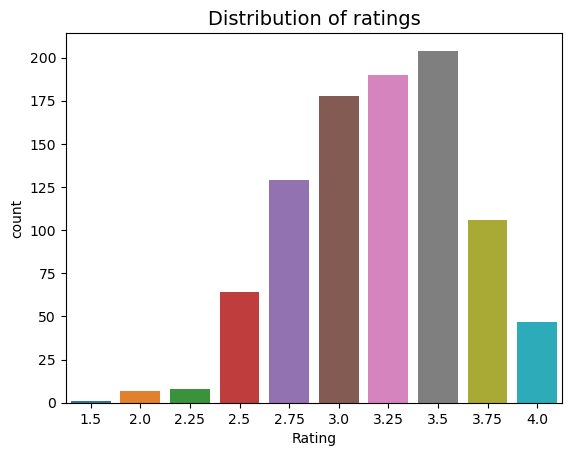

In [62]:
sns.countplot(x='Rating', data=df)
plt.title("Distribution of ratings", fontsize=14)
plt.show()

In [63]:
print(f"Mean global rating: {round(df['Rating'].mean(),2)}.")

Mean global rating: 3.21.


In [64]:
mean_ratings = ratings.groupby('REF')['Rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.2.


### Most frequently rated companies

In [65]:
df['COMPANY NAME'].value_counts()[0:10]

COMPANY NAME
Soma               56
Fresco             39
Arete              32
Dandelion          25
Guittard           22
Dick Taylor        19
Castronovo         19
Mast Brothers      18
Palette de Bine    15
Fruition           14
Name: count, dtype: int64

### The lowest and the highest rated companies

In [66]:
mean_ratings = df.groupby('COMPANY NAME')[['Rating']].mean()
lowest_rated = mean_ratings['Rating'].idxmin()

df[df['COMPANY NAME'] ==  lowest_rated].head(1)

,REF,COMPANY NAME,Most Memorable Characteristics,Rating
507,1189,Marsatta,"waxy, rubber, medicinal",2.25


In [67]:
highest_rated = mean_ratings['Rating'].idxmax()

df[df['COMPANY NAME'] ==  highest_rated].head(1)

,REF,COMPANY NAME,Most Memorable Characteristics,Rating
633,196,Patric,"mild tart, wine, red fruit, long",4.0


### Characteristics

In [68]:
list_stopwords = set(stopwords.words('english'))

In [69]:
copyy = df.copy()

In [70]:
df['Caracteristics'] = df['Most Memorable Characteristics'].str.lower()
df['Caracteristics'] = df['Caracteristics'].apply(word_tokenize)
df['Caracteristics'] = df['Caracteristics'].apply(lambda x: [word for word in x if word not in list_stopwords])
df['Caracteristics'] = df['Caracteristics'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df['Caracteristics'] = df['Caracteristics'].apply(lambda x : [word for word in x if len(word) > 1])

In [71]:
caracteristic_frequency = Counter(c for caracteristics in df['Caracteristics'] for c in caracteristics)

print(f"There are {len(caracteristic_frequency)} caracteristics.")

caracteristic_frequency

There are 355 caracteristics.


Counter({'cocoa': 156,
         'fruit': 126,
         'sweet': 116,
         'roasty': 93,
         'nutty': 90,
         'mild': 88,
         'sour': 79,
         'earthy': 72,
         'intense': 71,
         'molasses': 58,
         'floral': 58,
         'rich': 56,
         'creamy': 56,
         'sandy': 55,
         'spicy': 50,
         'fatty': 45,
         'vanilla': 43,
         'bitter': 42,
         'tart': 42,
         'dried': 41,
         'sticky': 35,
         'woody': 35,
         'gritty': 34,
         'burnt': 33,
         'spice': 32,
         'berry': 32,
         'caramel': 30,
         'fruity': 29,
         'dry': 28,
         'coffee': 28,
         'smoke': 26,
         'brownie': 26,
         'roast': 24,
         'cherry': 23,
         'red': 22,
         'metallic': 22,
         'black': 20,
         'astringent': 20,
         'grassy': 20,
         'pungent': 19,
         'notes': 19,
         'dairy': 18,
         'complex': 18,
         'acidic': 18,
  

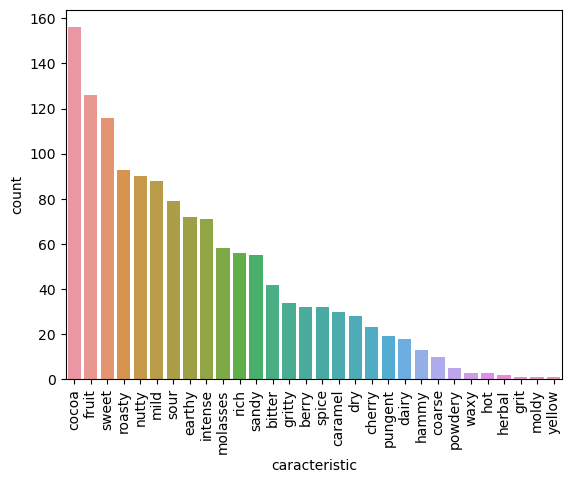

In [72]:
caracteristic_frequency_df = pd.DataFrame([caracteristic_frequency]).T.reset_index()
caracteristic_frequency_df.columns = ['caracteristic', 'count']

sns.barplot(x='caracteristic', y='count', data=caracteristic_frequency_df.head(30).sort_values(by='count', ascending=False))
plt.xticks(rotation=90);

### Data Preprocessing

In [73]:
def create_X(df):
    """
    Generates a sparse matrix.
    
    Args:
        df: pandas dataframe containing 3 columns (REF, COMPANY NAME, Rating)
    
    Returns:
        X: sparse matrix
        customer_mapper: dict that maps customer id's to customer indices
        company_mapper: dict that maps company id's to company indices
        customer_inv_mapper: dict that maps customer indices to customer id's
        company_inv_mapper: dict that maps company indices to company id's
    """
    M = df['REF'].nunique()
    N = df['COMPANY NAME'].nunique()

    customer_mapper = dict(zip(np.unique(df["REF"]), range(M)))
    company_mapper = dict(zip(np.unique(df["COMPANY NAME"]), range(N)))
    
    customer_inv_mapper = dict(zip(range(M), np.unique(df["REF"])))
    company_inv_mapper = dict(zip(range(N), np.unique(df["COMPANY NAME"])))
    
    user_index = [customer_mapper[i] for i in df['REF']]
    item_index = [company_mapper[i] for i in df['COMPANY NAME']]

    X = csr_matrix((df["Rating"], (user_index, item_index)), shape=(M, N))
    
    return X, customer_mapper, company_mapper, customer_inv_mapper, company_inv_mapper

X, customer_mapper, company_mapper, customer_inv_mapper, company_inv_mapper = create_X(df)

### Evaluating Sparsity

In [74]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.88%


In [75]:
n_ratings_per_customer = X.getnnz(axis=1)
len(n_ratings_per_customer)

401

In [76]:
n_ratings_per_company = X.getnnz(axis=0)
len(n_ratings_per_company)

170

C:\Users\kondr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kondr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


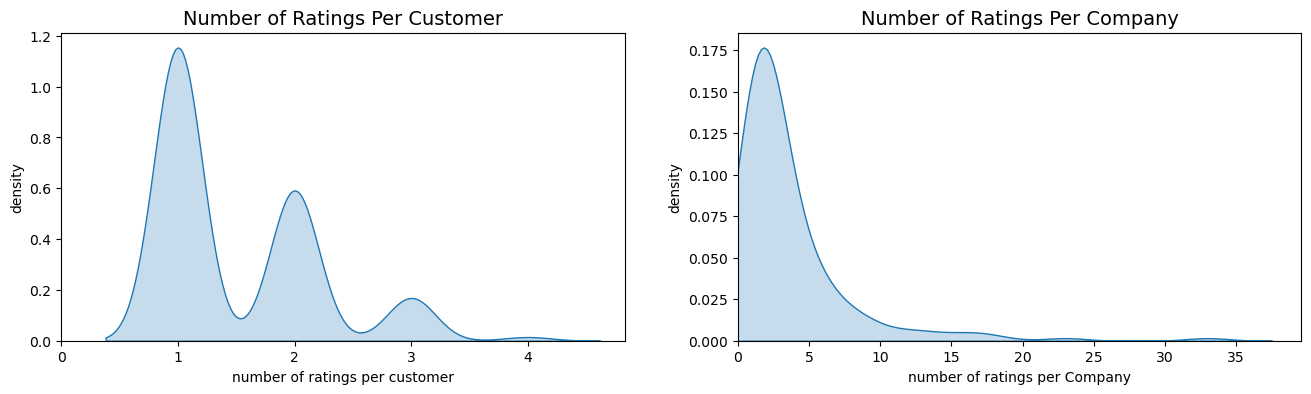

In [77]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_customer, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Customer", fontsize=14)
plt.xlabel("number of ratings per customer")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_company, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Company", fontsize=14)
plt.xlabel("number of ratings per Company")
plt.ylabel("density")
plt.show();

### Recommendations with k-Nearest Neighbors

In [78]:
def find_similar_companies(company, X, company_mapper, company_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given company.
    
    Args:
        company: company of interest
        X: user-item utility matrix
        k: number of similar companies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar companies and their similarity scores
    """
    X = X.T
    neighbour_ids = []
    similarity_scores = []  # Store similarity scores
    
    company_ind = company_mapper[company]
    company_vec = X[company_ind]
    if isinstance(company_vec, (np.ndarray)):
        company_vec = company_vec.reshape(1,-1)
    
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(company_vec, return_distance=False)
    
    for i in range(1, k+1):  # Start from 1 to exclude the input company
        n = neighbour.item(i)
        neighbour_ids.append(company_inv_mapper[n])
        similar_company_vec = X[n]
        similarity = cosine_similarity(company_vec, similar_company_vec)
        similarity_scores.append(similarity.item())
    
    return neighbour_ids, similarity_scores

#### Similar companies to Fresco based on rating

In [79]:
similar_companies, similarity_scores = find_similar_companies("Fresco", X, company_mapper, company_inv_mapper, 10)
print("If you liked Fresco, you may like:\n")
for comp, score in zip(similar_companies, similarity_scores):
    print(f"{comp} (Similarity Score: {score})")

If you liked Fresco, you may like:

Gotham (Similarity Score: 0.3365902235612376)
Kasama (Similarity Score: 0.2020140186431894)
Ninth (9th) & Larkin (Similarity Score: 0.09902570016033632)
Olivia (Similarity Score: 0.09696672894873092)
Dandelion (Similarity Score: 0.07377304534909679)
Ritual (Similarity Score: 0.05981754941704401)
Tocoti (Similarity Score: 0.05980468345612378)
Arete (Similarity Score: 0.05673866736059885)
Soma (Similarity Score: 0.04630726361501702)
TCHO (Similarity Score: 0.04487205908716322)


### Handling the cold-start problem

In [80]:
df

,REF,COMPANY NAME,Most Memorable Characteristics,Rating,Caracteristics
0,1462,Acalli,yellow fruit,3.75,"[yellow, fruit]"
1,1470,Acalli,"intense, nutty, cherry, cocoa",3.75,"[intense, nutty, cherry, cocoa]"
2,2462,Acalli,"herbal, molasses, hammy",3.25,"[herbal, molasses, hammy]"
3,2470,Acalli,"hot cocoa, rich, molasses",3.50,"[hot, cocoa, rich, molasses]"
4,1125,Altus aka Cao Artisan,"sweet, moldy, off",2.50,"[sweet, moldy]"
...,...,...,...,...,...
929,1582,Zak's,"very sweet, heavy roast, nuts",3.00,"[sweet, heavy, roast, nuts]"
930,1578,Zak's,"nutty, earthy, hammy",3.25,"[nutty, earthy, hammy]"
931,1578,Zak's,"sandy, mild sour, mild fruit",3.25,"[sandy, mild, sour, mild, fruit]"
932,1578,Zak's,"sandy, nutty, mocha",3.25,"[sandy, nutty, mocha]"


In [ ]:
cara = set(c for C in df['Caracteristics'] for c in C)

for c in cara:
    df[c] = df['Caracteristics'].transform(lambda x: int(c in x))
    
choc_cara = df.drop(columns=['REF', 'COMPANY NAME','Country of Bean Origin','Cocoa Percent','Ingredients','Rating', 'Most Memorable Characteristics', 'Caracteristics'])

In [82]:
choc_cara.head(3)

,coffee,soapy,aftertaste,diluted,base,lemon,vinegar,red,milk,flavor,...,cream,thick,overly,vegetal,hebs,miss,rubbery,cherry,current,moderate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
cosine_sim = cosine_similarity(choc_cara, choc_cara)

### Creating a company finder function

In [85]:
company_idx = dict(zip(df['COMPANY NAME'], list(df.index)))
idx = company_idx['Fresco']
print(f"Company index for Fresco: {idx}")

Company index for Fresco: 346


In [86]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1 : (n_recommendations+1)]

In [87]:
similar_companies = [i[0] for i in sim_scores]

In [88]:
print(f"Because you bought from Fresco:")
df['COMPANY NAME'].iloc[similar_companies]

Because you bought from Fresco:


501                Manoa
617      Palette de Bine
665              Potomac
268          Dick Taylor
359             Fruition
374          Great Lakes
581               Nuance
40                 Arete
143           Castronovo
284    East Van Roasters
Name: COMPANY NAME, dtype: object

In [89]:
def get_content_based_recommendations(title, n_recommendations=10):
    idx = company_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_companies = [(df['COMPANY NAME'].iloc[i], score) for i, score in sim_scores]
    return similar_companies

In [90]:
recommendations = get_content_based_recommendations("Fresco")
print("Because you bought from Fresco, you may like:\n")
for company, score in recommendations:
    print(f"{company} (Similarity Score: {score})")

Because you bought from Fresco, you may like:

Manoa (Similarity Score: 0.5)
Palette de Bine (Similarity Score: 0.5)
Potomac (Similarity Score: 0.5)
Dick Taylor (Similarity Score: 0.4472135954999579)
Fruition (Similarity Score: 0.4472135954999579)
Great Lakes (Similarity Score: 0.4472135954999579)
Nuance (Similarity Score: 0.4472135954999579)
Arete (Similarity Score: 0.35355339059327373)
Castronovo (Similarity Score: 0.35355339059327373)
East Van Roasters (Similarity Score: 0.35355339059327373)


### Dimensionality Reduction with Matrix Factorization

Matrix factorization (MF) is a linear algebra technique that can help to discover latent features underlying the interactions between customers and companies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents.

In [45]:
svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(170, 20)

In [ ]:
company_name = 'Patric'
similar_companies = find_similar_companies(company_name, Q.T, company_mapper, company_inv_mapper, metric='cosine', k=10)

print(f"Because you bought from {company_name}, you may like:/n")
for i in similar_companies:
    print(i)

The results above are the most similar companies to Patric using kNN on “compressed” company-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as chocolate characteristic.